In [1]:
import sys
sys.path.append("../")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sns.set_context('paper')
import logging
logging.basicConfig(format='%(asctime)s %(levelname)-7s %(message)s',
                    stream=sys.stderr, level=logging.INFO)
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.INFO)

import os

from pathlib import Path
import pandas as pd
import numpy as np
import json
import math

#In-house Module Imports
from config import Configuration 

In [4]:
def calculate_stats(df, score_type):
    
    stats = df.groupby(['query_strategy','query_iter'])[score_type].agg(['mean', 'count', 'std'])

    ci95_hi = []
    ci95_lo = []
    z_star = 1.96 # 1.65: ci90

    for i in stats.index:
        m, c, s = stats.loc[i]#[2:5]
        #ci95_hi.append(np.round(m + z_star*s/math.sqrt(c),2))
        ci95_hi.append(m + z_star*s/math.sqrt(c))
        ci95_lo.append(m - z_star*s/math.sqrt(c))

    stats['ci95_hi'] = ci95_hi
    stats['ci95_lo'] = ci95_lo

    stats.reset_index(['query_strategy','query_iter'], inplace=True)    
    
    return stats

In [6]:
#Update these

SYSTEM = 'volta'
FE_NAME = 'tsfresh'

if SYSTEM == 'volta':
    PARENT_DIR = 'active_learning_experiments'# 'active_learning_experiments_final_hdfs'
    
elif SYSTEM == 'eclipse':
    PARENT_DIR = 'active_learning_experiments_final_hdfs'# 'active_learning_experiments_final_hdfs'
    
EXP_NAME = f'{FE_NAME}_experiments'
DIR_NAME_TO_GENERATE_RESULTS = 'exp_1_active_learning' #batch_unseen_app_results

In [7]:
OUTPUT_DIR = f'/projectnb/peaclab-mon/{user}/{PARENT_DIR}' # or feature_extraction_experiments
CV_INDEX = 0
SCALER = 'None' #For now, do the scaling inside the notebook, then you can move that to the class function

In [ ]:
conf = Configuration(ipython=True,
                     overrides={
                         'output_dir': Path(OUTPUT_DIR), #change
                         'system' : SYSTEM,
                         'exp_name':EXP_NAME,                                                  
                         'cv_fold':CV_INDEX, 
                         'model_config': DIR_NAME_TO_GENERATE_RESULTS
                     })

In [ ]:
result_df = pd.DataFrame()
counter = 0
result_list = []

for cv_index in [0,1,2,3,4]:

    conf = Configuration(ipython=True,
                         overrides={
                             'output_dir': Path(OUTPUT_DIR), #change
                             'system' : SYSTEM,
                             'exp_name':EXP_NAME,                                                  
                             'cv_fold':cv_index, 
                             'model_config': DIR_NAME_TO_GENERATE_RESULTS
                         }
                        )

    for filename in os.listdir(conf['results_dir']):
        
        if  not "app-anom-selection" in filename:
            only_filename = filename.split('.')
            splitted_filename = only_filename[0].split('#')
            train_apps = splitted_filename[0].split(':')[1]
            test_apps = splitted_filename[1].split(':')[1]
            num_unknown_test_apps = len(test_apps.split("-"))
            num_known_train_apps = len(train_apps.split("-"))        

            temp_csv = pd.read_csv(Path(conf['results_dir']) / filename,index_col = [0])
            temp_csv['train_apps'] = train_apps
            temp_csv['test_apps'] = test_apps        
            temp_csv['num_unknown_test_apps'] = num_unknown_test_apps
            temp_csv['num_known_train_apps'] = num_known_train_apps
            temp_csv['repeat_num'] = int(splitted_filename[8])

            result_list.append(temp_csv)

            counter += 1
               

            result_df = pd.concat(result_list, axis=0)

In [132]:
result_df.loc[result_df['model'] == 'Proctor','query_strategy'] = "proctor"

In [ ]:
result_df.loc[result_df['method'] == 'random','method'] = 'baseline'

unique_models = result_df['model'].unique()
logging.info("Unique models: %s",unique_models)
unique_query_strategies = result_df['query_strategy'].unique()
logging.info("Unique query strategies: %s",unique_query_strategies)
unique_methods = result_df['method'].unique()
logging.info("Unique Methods: %s", unique_methods)
unique_fe_methods = result_df['fe'].unique()
logging.info("Feature Extraction Methods: %s",unique_fe_methods)
unique_feature_counts = sorted(result_df['feature_count'].unique())
logging.info("Num Features: %s", unique_feature_counts)
unique_query_sizes = sorted(result_df['query_size'].unique())
logging.info("Unique query sizes: %s",unique_query_sizes)
unique_known_train_apps = result_df['num_known_train_apps'].unique()
logging.info("Number of Known Apps in the Training: %s", unique_known_train_apps)

unique_random_selection = len(result_df[result_df['query_strategy'] == 'random']['repeat_num'].unique())
logging.info("Number of Repeats for the Random Selection: %s", unique_random_selection)

unique_folds = len(result_df[result_df['query_strategy'] != 'random']['fold'].unique())
logging.info("Number of Folds for the Active Learning Methods: %s", unique_folds)

In [134]:
result_df[result_df['model'] == "Proctor"]['repeat_num'].unique()

array([4, 0, 9, 6, 7, 8, 5, 3, 1, 2])

## Paper Plots

In [10]:
color_dict = {
    
            'entropy': '#ffa600',
            'margin': '#9a8f00',  
            'uncertainty': 'xkcd:blue',   
            'random': 'tab:green',
            'equal_app' : '#f96d2d',
            'proctor' : '#7a0061'
    
             }

param_dict = {
                'fig_width': 48,
                'fig_height': 12,
                'y_label_font': 40,
                'x_label_font': 40,
                'x_ticks_font': 37,
                'y_ticks_font': 37,    
                'legend_size': 42,
                'legend_title_size': 40,
                'title_size': 46,
                'title_pad': 40, 
                'fig_title_size': 50,
    
             }

In [11]:
selected_model = 'RandomForestClassifier'
num_query = 250
feature_count = 2000

In [137]:
naming_dict = {}
naming_dict['fe_name'] = FE_NAME
naming_dict['system'] = SYSTEM
naming_dict['num_features'] = int(feature_count)
naming_dict['num_queries'] = num_query  
naming_dict['model'] = selected_model

In [138]:
selected_result_df = result_df[(result_df['query_size'] == num_query) & result_df['model'].isin([selected_model,'Proctor'])]

stats_fscore = calculate_stats(selected_result_df, 'macro_avg_f1_score')
stats_far = calculate_stats(selected_result_df, 'false_alarm_rate')
stats_amr = calculate_stats(selected_result_df, 'anomaly_miss_rate')

In [140]:
def plot_multiple_query_line_plot(fscore_df, far_df, amr_df, param_dict, naming_dict, color_dict, num_query=50, use_std=False):
    
    
    fig, axs = plt.subplots(1,3,figsize=(param_dict['fig_width'], param_dict['fig_height']))
    
    for ind, (stats_df,fig_title, fig_y_label) in enumerate(zip([fscore_df,far_df,amr_df],["F1-score","False Alarm Rate","Anomaly Miss Rate"],["F1-score (Macro Avg)","",""])):
        
        strategies = stats_df['query_strategy'].unique()
        
        for strategy in strategies:
            
            selected_score_data = stats_df.loc[stats_df['query_strategy'] == strategy]
            x = selected_score_data['query_iter']
            y = selected_score_data['mean']
            axs[ind].plot(x, 
                     y,
                     linewidth=3,
                     color=color_dict[strategy],
                     label=strategy)

            if use_std:
                axs[ind].fill_between(x, 
                                 y - (1*selected_score_data['std']), 
                                 y + (1*selected_score_data['std']),
                                 alpha=0.2,  
                                 color=color_dict[strategy],
                                )
            else:

                axs[ind].fill_between(x, 
                     selected_score_data['ci95_lo'], 
                     selected_score_data['ci95_hi'],
                     alpha=0.1, 
                     color=color_dict[strategy],
                    )     
                
        if naming_dict['system'] == 'eclipse':
            axs[ind].axvline(x=200, linewidth=4, color='xkcd:black', linestyle='--', label="$Min Query_{F1_{95}}$")                 
        elif naming_dict['system'] == 'volta':
            axs[ind].axvline(x=21, linewidth=4, color='xkcd:black', linestyle='--', label="$Min Query_{F1_{95}}$")                 

        if naming_dict['system'] == 'eclipse':
            axs[0].axhline(y=0.95, linewidth=4, color='r', linestyle='--', label="$F1_{95}$")                 
        elif naming_dict['system'] == 'volta':
            axs[0].axhline(y=0.95, linewidth=4, color='r', linestyle='--', label="$F1_{95}$")                 

            
        axs[ind].set_title(fig_title, fontsize=param_dict['title_size'])     
        axs[ind].set_xlim([0, num_query])
        
        axs[ind].set_ylabel(f"{fig_y_label}",size=param_dict['y_label_font'])
        axs[ind].set_xlabel("Number of Queries",size=param_dict['x_label_font'])
        axs[ind].tick_params(axis='x', labelsize=param_dict['x_ticks_font'])
        axs[ind].tick_params(axis='y', labelsize=param_dict['y_ticks_font'])                
    
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, ['Entropy','Equal App*','Margin','Proctor*', 'Random*','Uncertainty',"$Min Query_{F1_{95}}$", "$F1_{95}$"], loc='lower left', 
               bbox_to_anchor=(0.065, 1, 0.3, 0.4), ncol=8, frameon=True, mode='None',
               prop={'size': param_dict['legend_size']}
              )
        
    #fig.suptitle(f"Active Learning with {naming_dict['model']}",fontsize=param_dict['fig_title_size'])        
    fig.suptitle("") 
    plt.tight_layout()
    plt.savefig(f"/usr3/graduate/baksar/projectx/AI4HPCAnalytics/src/active_learning_experiments/plots/{naming_dict['system']}_{naming_dict['fe_name']}_al.pdf", bbox_inches='tight')


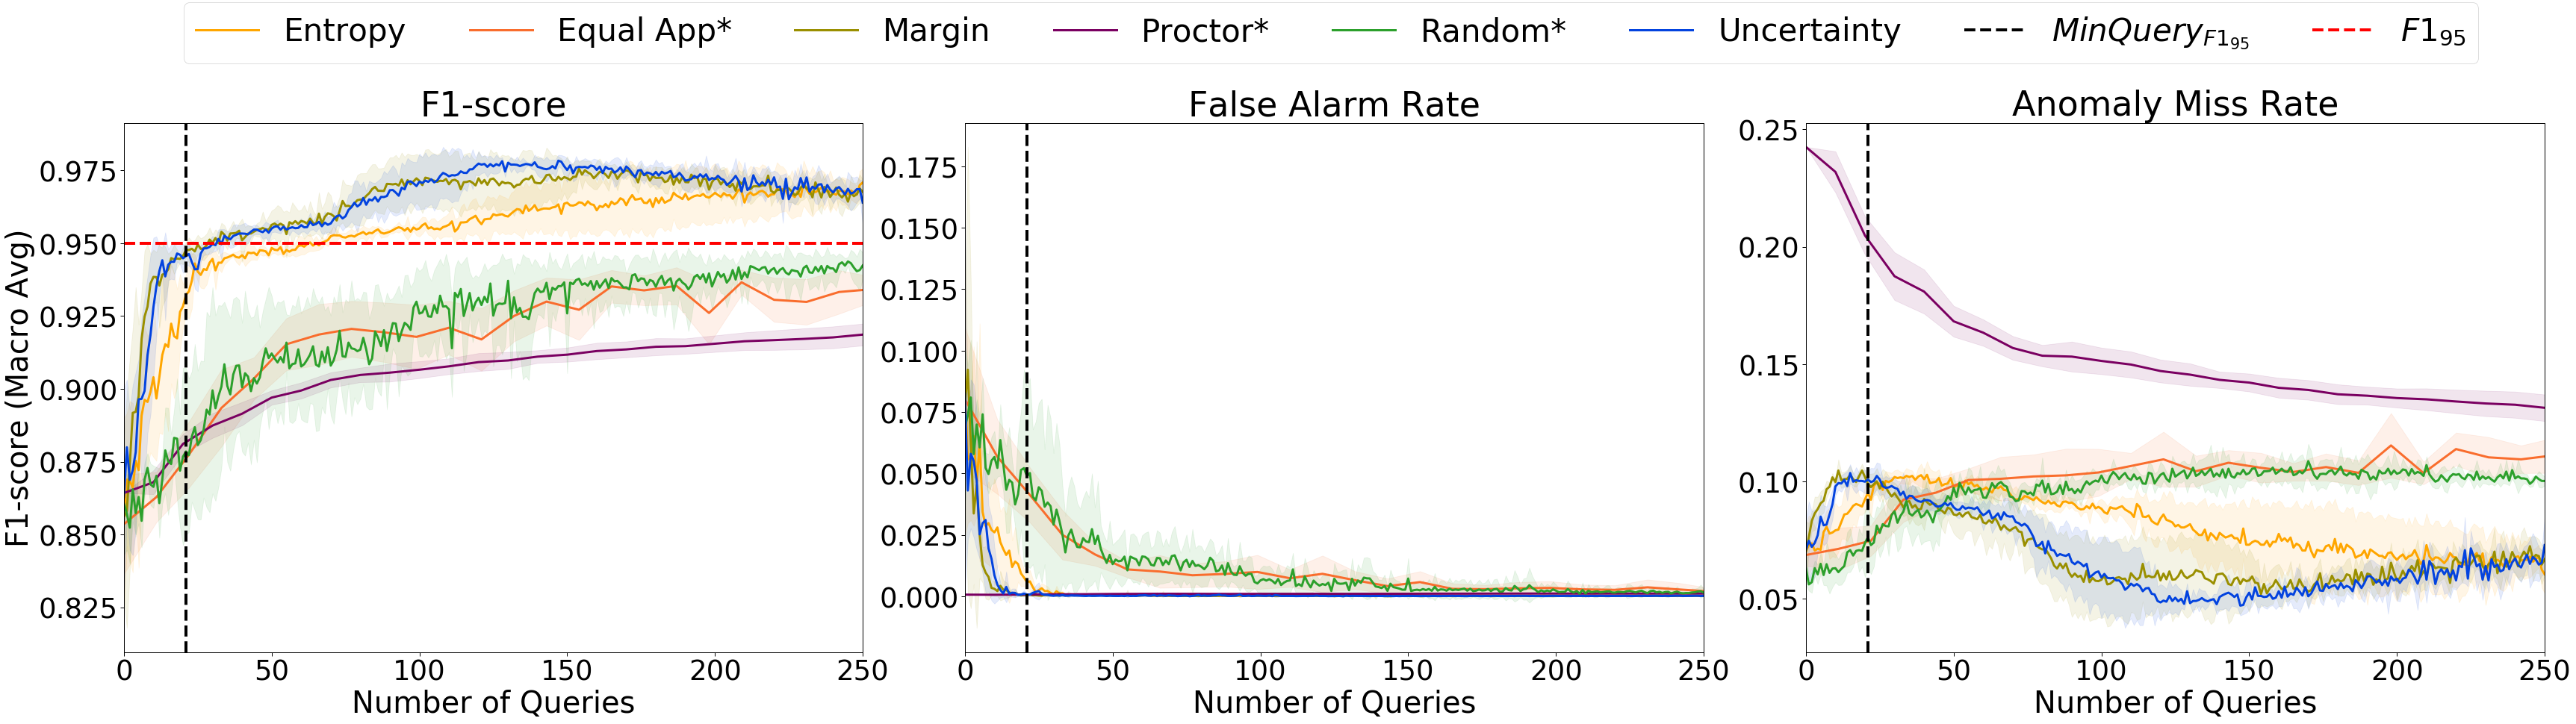

In [141]:
plot_multiple_query_line_plot(stats_fscore, 
                              stats_far, 
                              stats_amr, 
                              param_dict, 
                              naming_dict, 
                              color_dict, 
                              num_query=num_query,
                              use_std=False)

## Plot for Each Feature Extraction Method

In [ ]:
def plot_query_line_plot(stats_df,param_dict,naming_dict, color_dict, num_query=50, use_std=False):
    
    strategies = stats_df['query_strategy'].unique()

    fig = plt.figure(figsize=(param_dict['fig_width'], param_dict['fig_height']))

    for strategy in strategies:
        selected_score_data = stats_df.loc[stats_df['query_strategy'] == strategy]
        x = selected_score_data['query_iter']
        y = selected_score_data['mean']
        plt.plot(x, 
                 y,
                 linewidth=3,
                 color=color_dict[strategy],
                 label=strategy)
        if use_std:
            plt.fill_between(x, 
                             y - (1*selected_score_data['std']), 
                             y + (1*selected_score_data['std']),
                             alpha=0.2,  
                             color=color_dict[strategy],
                            )
        else:
            
            plt.fill_between(x, 
                 selected_score_data['ci95_lo'], 
                 selected_score_data['ci95_hi'],
                 alpha=0.1, 
                 color=color_dict[strategy],
                )

    legend = plt.legend(title="",prop={'size': param_dict['legend_size']})
    
    plt.title(f"{naming_dict['title_prefix']} w.r.t Number of Queries \n {naming_dict['model']} - {naming_dict['fe_name']} - {naming_dict['system']} - {naming_dict['num_features']} \n",fontsize=param_dict['title_size'])
    plt.xlim([0, num_query])

    plt.ylabel(f"{naming_dict['title_prefix']}",size=param_dict['y_label_font'])
    plt.xlabel("Number of Queries",size=param_dict['x_label_font'])
    plt.xticks(fontsize=param_dict['x_ticks_font'])
    plt.yticks(fontsize=param_dict['y_ticks_font'])
    
    plt.show()

In [180]:
color_dict = {
                'entropy': 'tab:purple',
                'margin': 'tab:blue',    
                'uncertainty': 'orange',    
                'random': 'tab:green',
                'equal_app' : 'tab:red',
             }

In [181]:
param_dict = {
                'fig_width': 18,
                'fig_height': 12,
                'y_label_font': 45,
                'x_label_font': 45,
                 'x_ticks_font': 42,
                 'y_ticks_font': 50,    
                'legend_size': 30,
                'legend_title_size': 40,
                'title_size': 36,
                'title_pad': 40,             
             }

In [ ]:
num_query = 250
feature_count = unique_feature_counts[0]

for unique_model in unique_models:
    selected_result_df = result_df[(result_df['query_size'] == num_query) & (result_df['model'] == unique_model)]
    stats_fscore = calculate_stats(selected_result_df, 'macro_avg_f1_score')
    stats_far = calculate_stats(selected_result_df, 'false_alarm_rate')
    stats_amr = calculate_stats(selected_result_df, 'anomaly_miss_rate')
    
    naming_dict = {}
    naming_dict['fe_name'] = FE_NAME
    naming_dict['system'] = SYSTEM
    naming_dict['num_features'] = int(feature_count)
    naming_dict['num_queries'] = num_query  
    naming_dict['model'] = unique_model
    
    naming_dict['title_prefix'] = "F1-Score (Macro Avg)"
    plot_query_line_plot(stats_fscore, param_dict, naming_dict, color_dict, num_query=num_query)   
    
    naming_dict['title_prefix'] = "False Alarm Rate"
    plot_query_line_plot(stats_far, param_dict, naming_dict, color_dict, num_query=num_query)    
    
    naming_dict['title_prefix'] = "Anomaly Miss Rate"
    plot_query_line_plot(stats_amr, param_dict, naming_dict, color_dict, num_query=num_query)    